# A Pseudoproxy Experiment with GraphEM and pseudoPAGES2k

**Expected time to run through: TBD mins**

This tutorial demonstrates how to get a reconstruction using GraphEM, leveraging a simple pseudoproxy dataset generated from iCESM gridded, with the realistic spatial availability but full temporal avaiablity of the PAGES 2k version 2 dataset.
The pseudoproxies are generated based on the original iCESM simulated surface temperature (`tas`) plus white noise with `SNR=10`.

The workflow works like this:

- Step 0: Data and code setup
- Step 1: Job Configuration
- Step 2: Graph Estimation
- Step 3: Reconstruction
- Step 4: Validation


## Step 0: Data and code setup

To go through this tutorial, please prepare test data following the steps:

1. **Download the pseudoproxy data** (“PPE_PAGES2k”) at this [link](https://drive.google.com/drive/folders/1_h6o_gDR6xLX50c_Ad-lzRoWwHlAgBnK?usp=sharing).
Create a directory named “testcases” in the same directory where this notebook sits.
Put the unzipped direcotry “PPE_PAGES2k” into “testcases”.

1. **Load some useful packages**, including `GraphEM`.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import LMRt
import GraphEM
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as  plt

## Step 1: Job Configuration

In [2]:
job = GraphEM.ReconJob()  # initialize reconstruction job

In [3]:
job.load_configs('./testcases/PPE_PAGES2k/configs.yml', verbose=True)

GraphEM: job.load_configs() >>> loading reconstruction configurations from: ./testcases/PPE_PAGES2k/configs.yml
GraphEM: job.load_configs() >>> job.configs created
GraphEM: job.load_configs() >>> job.configs["job_dirpath"] = /Users/julieneg/Documents/GitHub/GraphEM/docsrc/tutorial/testcases/PPE_PAGES2k/recon
GraphEM: job.load_configs() >>> /Users/julieneg/Documents/GitHub/GraphEM/docsrc/tutorial/testcases/PPE_PAGES2k/recon created
{'anom_period': [1951, 1980],
 'calib_period': [1900, 2000],
 'job_dirpath': '/Users/julieneg/Documents/GitHub/GraphEM/docsrc/tutorial/testcases/PPE_PAGES2k/recon',
 'job_id': 'GraphEM_tutorial',
 'obs_path': {'tas': './data/obs/iCESM_ann.nc'},
 'obs_regrid_ntrunc': 21,
 'obs_varname': {'lat': 'lat', 'lon': 'lon', 'tas': 'tas'},
 'proxydb_path': './data/proxy/pseudoPAGES2k_dataset_tas_wn_SNR10_full_temporal_availability.pkl',
 'ptype_list': 'all',
 'recon_period': [1000, 2000]}


In [4]:
job.load_proxydb(verbose=True)

GraphEM: job.load_proxydb() >>> job.configs["proxydb_path"] = /Users/julieneg/Documents/GitHub/GraphEM/docsrc/tutorial/testcases/PPE_PAGES2k/data/proxy/pseudoPAGES2k_dataset_tas_wn_SNR10_full_temporal_availability.pkl
GraphEM: job.load_proxydb() >>> 692 records loaded
GraphEM: job.load_proxydb() >>> job.proxydb created


To make sure everything loaded properly, it does not hurt to plot it:

/Users/julieneg/opt/miniconda3/envs/graphem/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/julieneg/opt/miniconda3/envs/graphem/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/julieneg/opt/miniconda3/envs/graphem/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(mul

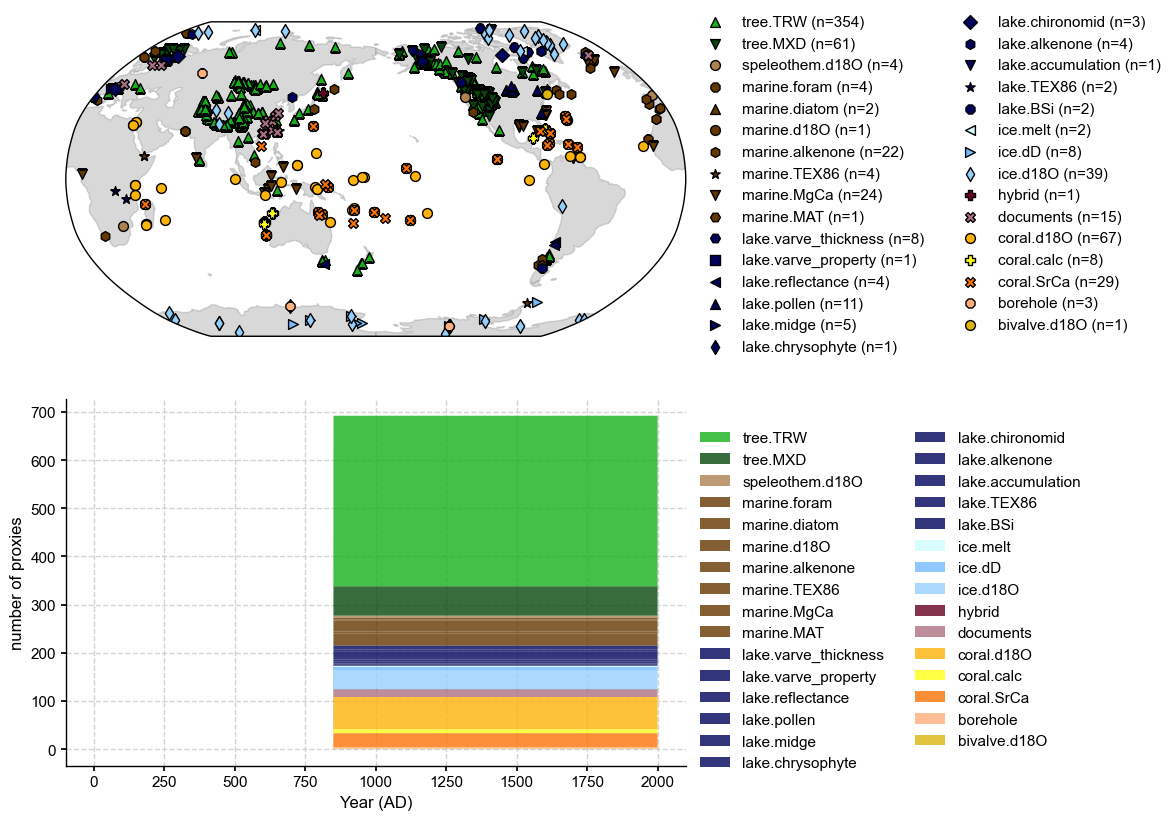

In [5]:
fig, ax = job.proxydb.plot()

In this case the data are available throughout the entire reconstruction period, which will greatly speed up computations.  We also load the "observations" (here, the temperature field from the iCESM model).

In [29]:
job.load_obs(verbose=True)
print(job.obs)

GraphEM: job.load_obs() >>> loading instrumental observation fields from: {'tas': '/Users/julieneg/Documents/GitHub/GraphEM/docsrc/tutorial/testcases/PPE_PAGES2k/data/obs/iCESM_ann.nc'}
GraphEM: job.load_obs() >>> job.obs created
Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/julieneg/Documents/GitHub/GraphEM/docsrc/tutorial/testcases/PPE_PAGES2k/data/obs/iCESM_ann.nc
    Shape:  time:1156, lat:96, lon:144


In [30]:
# OPTIONAL: regrid obs to make the problem size smaller
job.regrid_obs(ntrunc=25)

### Cropping the domain

To save computational resources, let's crop the domain to cover the 20N-70N region

In [31]:
#job.obs.crop([30, 70, np.mod(-130, 360), np.mod(-70, 360)], inplace=True)
job.obs.crop([20, 70, 0, 360], inplace=True)
print(job.obs)

Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/julieneg/Documents/GitHub/GraphEM/docsrc/tutorial/testcases/PPE_PAGES2k/data/obs/iCESM_ann.nc
    Shape:  time:1156, lat:7, lon:39


Since the loaded iCESM simulation and the pseudoproxy dataset are already annualized, we can skip the `.seasonalize()` steps and run `.prep_data()` directly.

In [32]:
job.prep_data(verbose=True)

GraphEM: job.prep_data() >>> job.recon_time created
GraphEM: job.prep_data() >>> job.calib_time created
GraphEM: job.prep_data() >>> job.calib_idx created
GraphEM: job.prep_data() >>> job.temp created
GraphEM: job.prep_data() >>> job.df_proxy created
GraphEM: job.prep_data() >>> job.proxy created
GraphEM: job.prep_data() >>> job.lonlat created


The pseudoproxy data are loaded into a `pandas` dataframe, which may be accessed thusly:

In [33]:
job.df_proxy

,NAm_153,Asi_245,NAm_165,Asi_178,Asi_174,Eur_016,Asi_198,NAm_145,Arc_070,Arc_071,...,Asi_119,Ocn_153,NAm_074,Asi_026,Ocn_169,Asi_201,Asi_179,Arc_014,Ocn_071,Ocn_072
1000.0,2.049447,1.206348,-0.028154,0.354423,0.164291,0.700894,0.420136,1.610386,1.250028,1.241505,...,0.828330,0.074526,1.969163,0.165617,0.331053,-0.578854,0.188152,1.255906,0.304311,0.425676
1001.0,0.014990,0.708525,0.246777,-0.057988,-0.127694,-0.077910,0.477898,-1.579350,-1.453855,1.689047,...,0.986828,-0.319637,1.589055,0.146957,-0.345228,-0.449773,0.128710,1.697772,-0.457480,-0.352040
1002.0,-1.114598,-0.355595,-0.903415,-0.370463,-0.170471,0.018887,0.820904,0.335598,0.658790,-1.006825,...,-0.571258,-0.268028,-2.308910,0.313561,-0.265528,-0.357028,0.152346,-0.037280,-0.357438,-0.312209
1003.0,0.921028,0.761262,-0.241008,-0.612394,-0.198821,0.600541,0.038012,1.649567,0.484537,-0.694430,...,0.332292,0.469818,1.270690,-0.172501,0.210101,-0.619913,-0.157362,-0.393430,0.248620,0.292726
1004.0,0.292958,-0.005126,0.781568,-0.169216,0.314034,-0.194410,0.990756,-0.391326,-1.263733,1.176845,...,0.160528,-0.084175,0.971972,0.342813,-0.134291,1.254460,0.379938,1.061491,-0.126194,-0.164533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996.0,0.596161,0.397911,-0.213472,-0.375964,0.110367,-0.175807,1.092398,2.554041,2.983670,-0.233084,...,0.086505,0.938570,-0.516218,0.099238,0.489292,0.470537,-0.122144,-0.671030,0.416049,0.440858
1997.0,0.708165,-0.204674,0.940863,-0.811482,-0.402413,0.229789,1.386490,0.106067,-0.278486,-0.677213,...,-0.236382,0.109457,-0.916285,-0.319777,-0.009780,0.513189,-0.707492,-1.106939,-0.174881,-0.218647
1998.0,0.502749,-0.240407,1.346490,0.595868,0.373318,0.085835,0.838359,0.328611,1.795783,2.179380,...,-0.454328,0.489631,0.177895,0.388473,0.009699,0.821627,0.307725,1.840054,-0.005446,0.060198
1999.0,1.476074,-0.101115,0.071156,0.010010,0.215712,-0.452304,-0.450495,2.144862,1.877791,-0.456210,...,0.340616,0.543951,0.590506,0.229498,0.373771,0.036311,-0.097946,-0.597891,0.509028,0.404405


In [34]:
print(np.shape(job.temp))
print(np.shape(job.proxy))
print(np.shape(job.lonlat))

(1001, 273)
(1001, 692)
(965, 2)


We see that the number of columns (692 proxies + the temperature gridpoints) $p \gg n = 150$ so the regression will need to be heavily regularized to give meaningful results. It is now time to save all this into a pickle file, for traceability:

In [35]:
job.save(verbose=True)

LMRt: job.save_job() >>> Prepration data saved to: /Users/julieneg/Documents/GitHub/GraphEM/docsrc/tutorial/testcases/PPE_PAGES2k/recon/job.pkl
LMRt: job.save_job() >>> job.configs["prep_savepath"] = /Users/julieneg/Documents/GitHub/GraphEM/docsrc/tutorial/testcases/PPE_PAGES2k/recon/job.pkl


## Step 2: Graph estimation

In GraphEM, the selection of the covariance model used for inferring missing values is based on a [graph](http://ir.hit.edu.cn/~jguo/docs/notes/report-in-princeton-research.pdf). 
Two types of graphs are supported:
1. **Neighborhood graphs**, structures that are imposed on the dataset 
2. **Empirical graph**s, learned from the data using a method called the graphical lasso ([glasso](https://en.wikipedia.org/wiki/Graphical_lasso))

Neighborhood graphs depend only on the distance between proxies and target field gridpoints, and declare as "neighbors" all points within a given geographical distance (in km). Computing intra-grid distances is a simple, one-time operation, so neighborhood graphs are extremely simple to set up and implement, and often lead to reasonable results. However, they are usually not taking advantage of all the conditional independence relations present in the dataset, and can be improved upon by using graphs learned empirically from the data, which _glasso_ facilitates. 


### 2.1. Neighborhood graph as initial guess

Because _glasso_ requires a full data matrix to estimate the graph, neighborhood graphs can serve as a very useful initial guess for the imputation, and also provide a complete matrix on which _glasso_ can work. 

In [36]:
%%time
g = GraphEM.Graph(job.lonlat, job.temp, job.proxy)
g.calc_distance()

CPU times: user 9.84 s, sys: 36.7 ms, total: 9.88 s
Wall time: 9.89 s


Now let us set up the adjancency matrix of the graph, and plot it.

In [37]:
g.calc_adj(distance=2000)
g.plot_neighbors(10)

(<Figure size 400x400 with 1 Axes>,
 <GeoAxesSubplot:title={'center':'Neighbors of the target proxy (r=2000 km)'}>)

In [38]:
%%time
save_path = './testcases/PPE_PAGES2k/recon/neighborhood2000.pkl'
job.run_solver(save_path=save_path, verbose=True, estimate_graph=False, graph=g.adj)

Running GraphEM:

Iter     dXmis     rdXmis

001     0.1052     0.5651
002     0.4861     2.2544
003     0.2415     0.4419
004     0.1600     0.2327
005     0.1071     0.1422
006     0.0772     0.0966
007     0.0630     0.0756
008     0.0555     0.0643
009     0.0493     0.0554
010     0.0446     0.0488
011     0.0409     0.0436
012     0.0382     0.0397
013     0.0363     0.0370
014     0.0341     0.0341
015     0.0326     0.0319
016     0.0321     0.0309
017     0.0309     0.0293
018     0.0304     0.0283
019     0.0301     0.0277
020     0.0309     0.0279
021     0.0300     0.0268
022     0.0295     0.0259
023     0.0286     0.0249
024     0.0275     0.0236
025     0.0262     0.0223
026     0.0262     0.0220
027     0.0240     0.0199
028     0.0228     0.0187
029     0.0219     0.0178
030     0.0212     0.0171
031     0.0206     0.0164
032     0.0201     0.0159
033     0.0196     0.0153
034     0.0192     0.0149
035     0.0210     0.0161
036     0.0189     0.0144
037     0.0197     

In [39]:
f_neigh = './testcases/PPE_PAGES2k/recon/neighborhood2000_recon.nc'
job.save_recon(f_neigh, verbose=True)

LMRt: job.save_recon() >>> Reconstruction saved to: ./testcases/PPE_PAGES2k/recon/neighborhood2000_recon.nc


## Validation

In [40]:
with xr.open_dataset(f_neigh) as ds:
    print(ds)

<xarray.Dataset>
Dimensions:  (year: 1001, lat: 7, lon: 39)
Coordinates:
  * year     (year) int64 1000 1001 1002 1003 1004 ... 1996 1997 1998 1999 2000
  * lat      (lat) float64 24.23 31.15 38.08 45.0 51.92 58.85 65.77
  * lon      (lon) float64 0.0 9.231 18.46 27.69 ... 323.1 332.3 341.5 350.8
Data variables:
    recon    (year, lat, lon) float64 ...


In [41]:
mask = (job.obs.fields['tas'].time >= 1000) & (job.obs.fields['tas'].time <= 2000)
target = job.obs.fields['tas'].value[mask]
print(np.shape(target))

(1001, 7, 39)


### Statistics on the global field

In [42]:
nt = np.size(ds['year'])
temp_r = job.recon.reshape((nt, -1))
V = GraphEM.solver.verif_stats(temp_r, target.reshape((nt, -1)), job.calib_idx)
print(V)

Mean MSE = 3.0297, Mean RE = -2.4486, Mean CE = -2.7388, Mean R2 = 0.1765


### Map of CE

In [43]:
ce = LMRt.utils.coefficient_efficiency(target, ds['recon'])
print(np.shape(ce))

(7, 39)


/Users/julieneg/opt/miniconda3/envs/graphem/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/julieneg/opt/miniconda3/envs/graphem/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/julieneg/opt/miniconda3/envs/graphem/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/var/folde

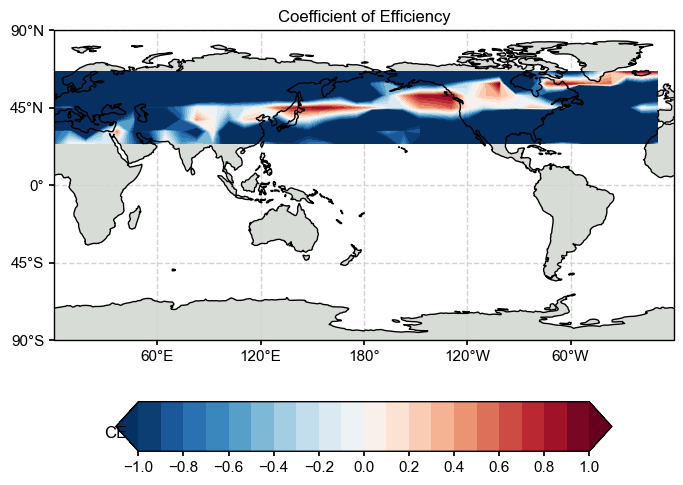

In [44]:
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig = plt.figure(figsize=[8, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('Coefficient of Efficiency')
latlon_range = [0, 360, -90, 90]
transform=ccrs.PlateCarree()

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

lon_ticks=[60, 120, 180, 240, 300]
lat_ticks=[-90, -45, 0, 45, 90]
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
lon_min, lon_max, lat_min, lat_max = latlon_range
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks[mask_lat], crs=ccrs.PlateCarree())

levels = np.linspace(-1, 1, 21)
cbar_labels = np.linspace(-1, 1, 11)
cbar_title = 'CE'
extend = 'both'
cmap = 'RdBu_r'
cbar_pad=0.1
cbar_orientation='horizontal'
cbar_aspect=10
cbar_fraction=0.35
cbar_shrink=0.8
font_scale=1.5
land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['white']
        
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()
im = ax.contourf(ds['lon'].values, ds['lat'].values, ce, levels, transform=transform, cmap=cmap, extend=extend)
cbar = fig.colorbar(
    im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.set_ticks(cbar_labels)
cbar.ax.set_title(cbar_title, x=-0.05, y=0.1)
    
LMRt.showfig(fig)

### Mean timeseries

In [45]:
import pyleoclim as pyleo

In [46]:
def geo_mean(field, lat):
    m = np.average(
        np.average(field, axis=-1), axis=-1, weights=np.cos(np.deg2rad(lat))
    )
    return m

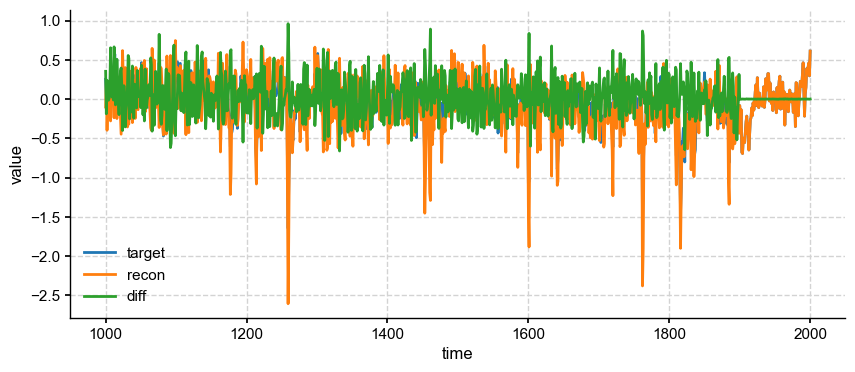

In [47]:
m_target = geo_mean(target, job.obs.fields['tas'].lat) 
ts_target = pyleo.Series(time=np.arange(1000, 2001), value=m_target)

m_recon = geo_mean(ds['recon'].values, ds['lat'].values)
ts_recon = pyleo.Series(time=ds['year'].values, value=m_recon)

fig, ax = ts_target.plot(mute=True, label='target')
ts_recon.plot(ax=ax, label='recon')
ax.plot(ds['year'].values, m_target-m_recon, label='diff')
ax.legend()
pyleo.showfig(fig)

There are at least two reasons why this is not a very good estimate:
1. neighborhood graphs are isotropic; climate fields are not
1. we used a relatively large cutoff radius (2000km), and did not bother to optimize it. 

TODO: implement K-fold CV (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

### 2.2. Graphical Lasso